**This notebook show the MSI and HSIfusion using SURE:**
- Data: The Pavia University dataset
    - Simulated LR HSI data are generated by apply the PSF filtering and downsampling to the HR HSI, and adding Gaussian noise. The noise is band-dependent where sigma is a bell-curve function (case 1) or random number from drawn from uniform distribution U(0, 0.1), i.e., $\mathbf{Y} = \mathbf{MBX} + \mathbf{n}$
    - Simulated MSI data are generated by downsampling the spectral using spectral respon function (SRF), e.g., Ikonos SRF, resulting 4 MSI bands. $\mathbf{Z} = \mathbf{RX}$
- Network: Modified version of the GDD (Uezato, T., Hong, D., Yokoya, N., & He, W. (2020, August). Guided deep decoder: Unsupervised image pair fusion. In European Conference on Computer Vision (pp. 87-102)).
- Loss function: $\mathcal{L}_\text{SURE}(\Theta)=\|\mathbf{y}-\mathbf{H}f_{\Theta}(\mathbf{y})\|_2^2+2\text{tr}\big(\Omega\mathbf{H}\frac{\partial{f_\Theta(\mathbf{y})}}{\partial{\mathbf{y}}} \big)$

In [1]:
# =============================================================================
# import lib
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.optim
import scipy.io as sio
from skimage.metrics import peak_signal_noise_ratio as psnr
from models.GDD import gdd
from models.common import *
from models.hs_models import *
from utils.hs_utils import *
# from utils.s2_utils import *
from utils.common_utils import *
import torch.optim.lr_scheduler as lr_scheduler
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(torch.cuda.current_device())
device='cuda'
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor


0


In [2]:
# =============================================================================
# load data
# =============================================================================
path_to_data = 'data/HS/pu.mat'
Xm = sio.loadmat(path_to_data)['Zim'] # Ground truth (HR HSI), Xm.shape = [200,200,93]
# Xm = Xm[:int(Xm.shape[0]/32)*32,:int(Xm.shape[1]/32)*32,:]
srf = sio.loadmat(path_to_data)['R'] #spectral response
R=np.transpose(srf)
factor=4
[r,c,n_channels]=Xm.shape
Xm_torch=torch.from_numpy(Xm).type(dtype)
R_torch=torch.from_numpy(R).type(dtype)
##########Simulate MSI bands
MSI=hwc2chw(hsi2msi(Xm_torch,R_torch))
sigmam = np.ones((MSI.shape[0],1))*0.001
msi_torch=MSI[None,:] #ms
msi = add_noise(msi_torch,sigmam)
##########Simulate HSI bands
####Get PSF for the HSI, gaussinan =False -->PSF in the Hysure paper
psf=get_hs_psf(N=5, n_channels = n_channels, gaussian=False)
xm=hwc2chw(torch.from_numpy(Xm).type(dtype))
xmm=xm[None,:]
####Generate LR-HSI by filtering, downsampling (factor = 4) and adding noise
hsi_LR = compute_Hx(xmm,psf,ratio=factor) #hs
sigmah = np.random.rand(n_channels,1)*0.1 # Case 2: Uniform sigma (0-0.1)

hsi_lr=add_noise(hsi_LR,sigmah)
sigmah=torch.from_numpy(sigmah).type(dtype)
sigmam=torch.from_numpy(sigmam).type(dtype)
ref = Xm #np
N=50*50*93

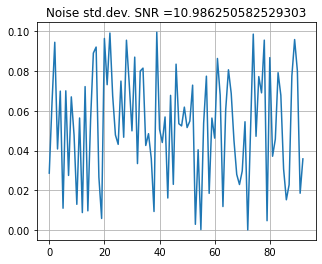

In [3]:
plt.figure(figsize=(5,4))
plt.plot(sigmah.cpu())
plt.title('Noise std.dev. SNR ='+str(sreCal(torch.squeeze(hsi_LR).cpu().numpy(),torch.squeeze(hsi_lr).cpu().numpy())))
plt.grid()

MS bands shape:  torch.Size([1, 4, 200, 200])
HS bands shape:  torch.Size([1, 93, 50, 50])


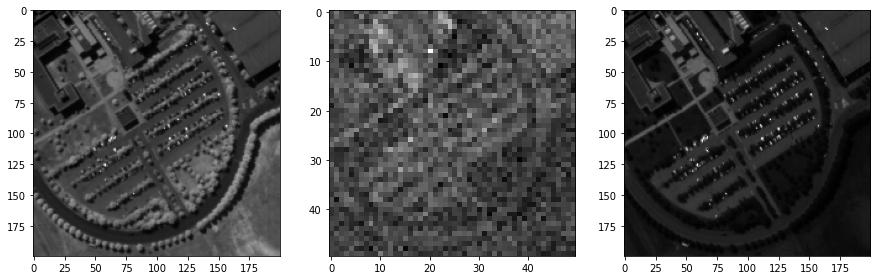

In [4]:
# =============================================================================
# show images
# =============================================================================
print('MS bands shape: ', msi.shape)
print('HS bands shape: ', hsi_lr.shape)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,15))
ax1.imshow(msi[0,3,:,:].cpu(),cmap='gray')
ax2.imshow(hsi_lr[0,11,:,:].cpu(),cmap='gray')
ax3.imshow(ref[:,:,11],cmap='gray')
plt.show()

In [5]:
# =============================================================================
# Set parameters and net
# =============================================================================
show_every = 100 #500
num_iter =5000
LR = 0.01 #try 0.01 0.001 0.0001
psf=get_hs_psf(n_channels = n_channels)

net=hs_net(ym_channel=4, yh_channel=n_channels, num_channels_down=64, 
           num_channels_up=64, num_channels_skip=64).type(dtype)

# noise = yh.detach().clone()
inputs=[msi_torch,hsi_lr]
targets=inputs
gband=4 #4 for ms
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
scheduler = lr_scheduler.StepLR(optimizer,step_size =500,gamma=0.5)

In [8]:
def hs_loss(model,inputs,targets,psf_hs, sigmah,sigmam,loss_type='dip'):
    '''SURE and DIP losses'''
    gband=4
    ym = inputs[0] #ms
    yh=inputs[1] #hs = target
    sigmah_sq=(sigmah.reshape([1,yh.shape[1],1,1]))**2
    sigmam_sq=(sigmam.reshape([1,ym.shape[1],1,1]))**2
    
    xhat=model(inputs) # size = [1, ms/pan_band+hsi_band, 200, 200]
#     N = xhat.shape[0]*xhat.shape[1]*xhat.shape[2]*xhat.shape[3]
    xhat_m=xhat[:,:gband,:,:]
    xhat_h=xhat[:,gband:,:,:]
    yhat_h=compute_Hx(xhat_h,psf_hs,ratio=4)
    dip_loss = torch.mean((yh-yhat_h)**2)+torch.mean((ym-xhat_m)**2)
    ####gdd loss
    out_msi_torch = hsi2msi(chw2hwc(xhat_h.squeeze()),R_torch)
    msi = chw2hwc(ym.squeeze())
    gdd_loss = torch.sum((msi-out_msi_torch)**2) + torch.sum((yh-yhat_h)**2)*0.1
    #### Compute the trace (divergence) term by using Monte-Carlo SURE  
    epsilon = 1e-6
    bh = torch.randn(inputs[1].shape).type(dtype)
    inp_bh = inputs[1] + epsilon * bh
    bm = torch.randn(inputs[0].shape).type(dtype)
    inp_bm = inputs[0] + epsilon * bm
    inp_bhh = [inp_bm, inp_bh]
  
    outb = (model(inp_bhh) - xhat) / epsilon  # [f(y+eb)-f(y)]/epsilon cho msi
    outb_m = outb[:,:gband,:,:]
    Houtb_h = compute_Hx(outb[:,gband:,:,:], psf_hs, ratio=4)

    div = 2 * torch.mean(sigmah_sq * bh * Houtb_h) + 2*torch.mean(sigmam_sq*bm*outb_m)
    sure_loss = dip_loss+div-torch.mean(sigmah_sq)+4e-5#-torch.mean(sigmam_sq)
    if loss_type=='dip':
        return div,dip_loss, xhat
    elif loss_type=='sure':
        return div, sure_loss, xhat
    else:
        return div, gdd_loss, xhat 

In [9]:
# =============================================================================
# Optimization
# =============================================================================
total_loss=[]
sre_history=[]
div_term = []
true_R=[]
yh_LR = torch.squeeze(hsi_LR) #yh_LR = Hx
y=torch.squeeze(msi_torch)
print('Starting optimization with ADAM')
sre_init=0.
loss_type="sure"
out_avg=None
exp_weight=0.99
for it in range(num_iter):
    optimizer.zero_grad()
    div, loss, out_HR = hs_loss(net,inputs,targets,psf,sigmah,sigmam,loss_type=loss_type)
    # Track the true R = ||Hx - Hx^||**2 and R^ = sure_loss
    out_HR_h = out_HR.detach()[:,gband:,:,:]
    out_m = out_HR.detach()[:,:gband,:,:].squeeze()
    out_LR_h = compute_Hx(out_HR_h,psf,4).squeeze()
    R = torch.mean((out_LR_h-yh_LR)**2) + torch.mean((out_m-y)**2)
    true_R.append(R)
    # Track the MSRE of reconstructed image
    out_np = chw2hwc(out_HR.detach().cpu().squeeze()).numpy()
    out_m = out_np[:,:,:gband]
    out_h = out_np[:,:,gband:]

#     if out_avg is None:
#         out_avg = out_h
#     else:
#         out_avg = out_avg * exp_weight + out_h * (1 - exp_weight)
#     if it==4000:
#         sio.savemat("out"+loss_type+"5"+".mat",mdict={"img_"+loss_type:out_avg})
    sre = psnr(ref,out_h)
    sre_history.append(sre)
    total_loss.append(loss.detach())
    loss.backward()
    optimizer.step()
    scheduler.step()
    if it % show_every == 0:
        # loss - E_eps should be approx. to R
        print('Iteration %05d  Loss = %.5f R =  %.5f  PSNR = %.3f' % (it,loss.detach()*N,R*N,sre))
#         f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
#         ax1.imshow(ref[:,:,41],cmap='gray')
#         ax2.imshow(out_np[:,:,41],cmap='gray')
#         ax3.imshow(ref[:,:,41],cmap='gray')
#         plt.show()

Starting optimization with ADAM


<ipython-input-9-c2d16378d1bf>:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  sre = psnr(ref,out_h)


Iteration 00000  Loss = 55864.98828 R =  55863.93750  PSNR = 9.320
Iteration 00100  Loss = 105.85206 R =  101.30769  PSNR = 31.957
Iteration 00200  Loss = 64.12262 R =  61.69087  PSNR = 33.684
Iteration 00300  Loss = 54.26205 R =  52.92131  PSNR = 34.582
Iteration 00400  Loss = 46.45617 R =  46.35613  PSNR = 35.300
Iteration 00500  Loss = 33.82604 R =  33.81662  PSNR = 35.985
Iteration 00600  Loss = 41.14933 R =  39.34721  PSNR = 35.892
Iteration 00700  Loss = 28.16924 R =  29.40440  PSNR = 36.607
Iteration 00800  Loss = 29.55710 R =  27.67671  PSNR = 36.845
Iteration 00900  Loss = 26.79610 R =  25.37615  PSNR = 37.062
Iteration 01000  Loss = 25.04624 R =  25.10095  PSNR = 36.993
Iteration 01100  Loss = 26.27084 R =  26.22466  PSNR = 36.926
Iteration 01200  Loss = 37.32272 R =  40.01211  PSNR = 36.394
Iteration 01300  Loss = 19.97153 R =  22.17685  PSNR = 37.285
Iteration 01400  Loss = 48.36739 R =  49.95576  PSNR = 35.960
Iteration 01500  Loss = 22.32898 R =  24.39386  PSNR = 37.190
I

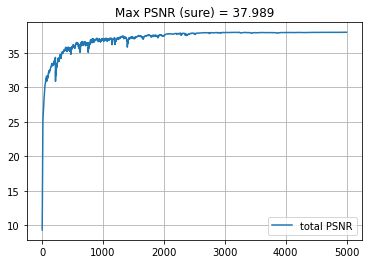

In [16]:
psnr_history=np.array(sre_history)
a=np.max(psnr_history)
plt.plot(psnr_history,label='total PSNR')

plt.title('Max PSNR ('+loss_type+') = '+str(np.round(a,3)))
plt.legend()
plt.grid()
plt.show()

In [ ]:
R=torch.Tensor(true_R).numpy()
loss = torch.Tensor(total_loss).numpy()
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.set_ylabel('Loss(log scale)',color='b')
ax2.tick_params(axis='y', labelcolor="b")
ax1.plot(losssure,'b',label='SURE loss')
ax1.plot(Rsure,'g--',label='R')
ax1.set_yscale("log")
# ax1.set_title('Max PSNR (sure) = '+str(np.round(a,3)))
ax1.legend()
ax1.grid()
ax1.legend(loc='best', bbox_to_anchor=(0.5, -0.2, 0.5, 0.5))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel("PSNR (dB)",color="k")  # we already handled the x-label with ax1
ax2.plot(psnrsure,'k',label='SURE')
ax2.plot(psnrdip,'k--',label='dip')

ax2.tick_params(axis='y', labelcolor="k")
ax2.legend( bbox_to_anchor=(0.5, 0.3, 0.5, 0.5))
fig.tight_layout()
plt.show()